<a href="https://colab.research.google.com/github/choderalab/pinot/blob/examples/examples/introduction_to_bayesian_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introcuction to Bayesian Optimization
=====================================
Yuanqing Wang (wangyq@wangyq.net)

In this example we show the basics of Bayesian optimization using `pinot`.

# Download and Install

In [8]:
! rm -rf /content/pinot
! git clone https://github.com/choderalab/pinot.git --depth=1
! cd /content/pinot && pip install -q -r requirements.txt && pip install -q .
! wget -q -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
! chmod +x Miniconda3-latest-Linux-x86_64.sh
! time bash ./Miniconda3-latest-Linux-x86_64.sh -q -b -f -p /usr/local
! time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import torch
import pinot

Cloning into 'pinot'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 255 (delta 21), reused 170 (delta 9), pack-reused 0
Receiving objects: 100% (255/255), 26.72 MiB | 14.99 MiB/s, done.
Resolving deltas: 100% (21/21), done.
     |████████████████████████████████| 3.0 MB 2.8 MB/s 
     |████████████████████████████████| 753.2 MB 10 kB/s 
     |████████████████████████████████| 1.6 MB 44.8 MB/s 
     |████████████████████████████████| 25.9 MB 129 kB/s 
     |████████████████████████████████| 829 kB 48.4 MB/s 
PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - ca-certificates==2020.1.1=0
    - certifi==2020.4.5.1=py37_0
    - cffi==1.14.0=py37he30daa8_1
    - chardet==3.0.4=py37_1003
    - conda-package-handling

In [9]:
! pip install gif

# Toy problem

## Toy data

We start with a toy problem on 1-D space: let's assume our 'goodness landscape' looks like this:

In [10]:
def f(x):
    """ Example from
    https://pyro.ai/examples/bo.html
    """
    return (6 * x - 2)**2 * torch.sin(12 * x - 4)

x = torch.linspace(0, 1)
y = f(x)


(-0.05, 1.05, -7.113203549385071, 16.922252678871153)

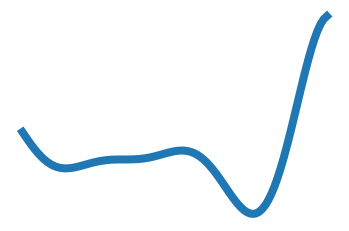

In [11]:
from matplotlib import pyplot as plt
plt.plot(x, y, linewidth=8)
plt.axis('off')

## Predictive model

A predictive model is needed for Bayesian optimization. As usual, we choose a simple two-layer neural network as the representation.

In [12]:
representation = torch.nn.Sequential(
    torch.nn.Linear(1, 32),
    torch.nn.Tanh(),
)

To form a complete model, we put a exact GP on top.

In [13]:
net = pinot.Net(
    representation=representation,
    output_regressor=pinot.regressors.ExactGaussianProcessRegressor,
)

## Bayesian optimization

Now we put this predictive model inside a Bayesian optimization experiment.

We pre-implemented several popular acquisition functions:

- **Probability of Improvement** characterizes the probability of the best current value,
$$
        \alpha_\text{PI}(x^* | \mathcal{D}, \mathbf{\theta}) = 1 - \Phi_{P(y^* | x^*, \mathbf{\theta})}(\operatorname{max}(y)),
$$
    where $\Phi$ denotes the CDF of the corresponding distribution, and $\max(y)$ is obtained within the training set $\mathcal{D} = \{\mathcal{G}_i, y_i\}$

- **Expected Improvement**, on the other hand, measures the expectation of the improvement over the current best,
    $$
        \alpha_\text{EI}(x^* | \mathcal{D}, \mathbf{\theta}) = \mathbb{E}_{P(y^* | x^*, \mathbf{\theta})}[\max \{y^* - \operatorname{max}(y), 0\}].
    $$

- **Upper Confidence Bound** is a more recent idea that exploits confidence bounds to minimize the regret. Note that the confidence of the bound $\kappa$ is a tunable parameter and could be used to balance exploitation against exploration.
    $$
        \alpha_\text{UCB}(x^* | \mathcal{D}, \mathbf{\theta}) = \operatorname{CI}_\kappa(P(y^* | x^*, \mathbf{\theta}))
    $$

Here we choose UCB (with $\kappa=0.95$) for the experiment.


In [7]:
bo = pinot.active.experiment.BayesOptExperiment(
        net=net,
        data=(x[:, None], y[:, None]),
        optimizer=torch.optim.Adam(net.parameters(), 1e-3),
        acquisition=pinot.active.acquisition.upper_confidence_bound,
        slice_fn=pinot.active.experiment._slice_fn_tensor_pair,
        n_epochs=10)

To visualize, we take the predictive distribution from each step out and put into a list. The logic is the same as `bo.run()`.

In [ ]:
distributions = []

In [ ]:
limit = 9999
idx = 0
bo.blind_pick()
bo.update_data()

while idx < limit and len(bo.new) > 0:
    bo.train()
    bo.acquire()
    bo.update_data()
    idx += 1
    distributions.append(bo.net.condition(x[:, None]))

In [15]:
import gif
@gif.frame
def plot(idx):
    old = bo.old
    plt.figure()
    plt.plot(x, y)
    plt.scatter(x[old[:idx]], y[old[:idx]])
    
    distribution = distributions[idx]
    
    from pinot.samplers.utils import confidence_interval
    
    low, high = confidence_interval(distribution, 0.95, n_samples=100)
    plt.fill_between(
        x.flatten().detach(), 
        low.flatten().detach(), 
        high.flatten().detach(), 
        color='k', 
        alpha=0.1)
    
    low, high = confidence_interval(distribution, 0.75, n_samples=100)
    plt.fill_between(
        x.flatten().detach(), 
        low.flatten().detach(), 
        high.flatten().detach(), 
        color='k', 
        alpha=0.2)
    
    low, high = confidence_interval(distribution, 0.50, n_samples=100)
    plt.fill_between(
        x.flatten().detach(), 
        low.flatten().detach(), 
        high.flatten().detach(), 
        color='k', 
        alpha=0.3)
    
    low, high = confidence_interval(distribution, 0.20, n_samples=100)
    plt.fill_between(
        x.flatten().detach(), 
        low.flatten().detach(), 
        high.flatten().detach(), 
        color='k', 
        alpha=0.4)
    
    plt.ylim(-10, 20)

    plt.axis('off')

In [ ]:
frames = [plot(idx) for idx in range(len(distributions))]
gif.save(frames, "gp.gif", duration=100)

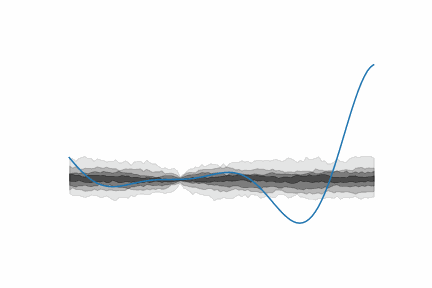

In [ ]:
from IPython.display import Image
Image('gp.gif', format='png')

See how it grabs the best candidate with the first few acquisitions.

For the sake of comparison, we also plot with predictive model being MLE.

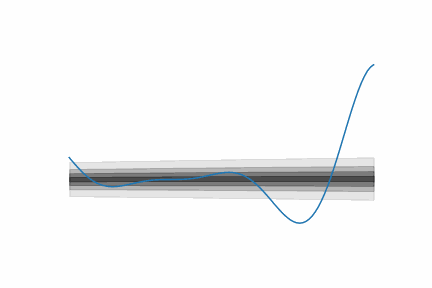

In [16]:
representation = torch.nn.Sequential(
    torch.nn.Linear(1, 32),
    torch.nn.Tanh(),
)

net = pinot.Net(
    representation=representation,
    output_regressor=pinot.regressors.NeuralNetworkRegressor,
)

bo = pinot.active.experiment.BayesOptExperiment(
        net=net,
        data=(x[:, None], y[:, None]),
        optimizer=torch.optim.Adam(net.parameters(), 1e-3),
        acquisition=pinot.active.acquisition.upper_confidence_bound,
        slice_fn=pinot.active.experiment._slice_fn_tensor_pair,
        n_epochs=10)

distributions = []

limit = 9999
idx = 0
bo.blind_pick()
bo.update_data()

while idx < limit and len(bo.new) > 0:
    bo.train()
    bo.acquire()
    bo.update_data()
    idx += 1
    distributions.append(bo.net.condition(x[:, None]))

frames = [plot(idx) for idx in range(len(distributions))]
gif.save(frames, "mle.gif", duration=100)

from IPython.display import Image
Image('mle.gif', format='png')

It also got the best candidate shortly.

# Let's solve COVID

## Data

We use the data from COVID Moonshot project to demonstrate Bayesian optimization on chemical graph space.

In [21]:
ds = pinot.data.moonshot()
ds = pinot.data.utils.batch(ds, len(ds))

## Predictive model

In [34]:
layer = pinot.representation.dgl_legacy.gn(model_name='GraphConv')
representation = pinot.representation.Sequential(
    layer=layer,
    config=[32, 'tanh', 32, 'tanh', 32, 'tanh']
)
output_regressor = pinot.regressors.ExactGaussianProcessRegressor
net = pinot.Net(
    representation=representation,
    output_regressor=output_regressor
)


## Bayesian Optimization

In [35]:
bo = pinot.active.experiment.BayesOptExperiment(
        net=net,
        data=ds[0],
        optimizer=torch.optim.Adam(net.parameters(), 1e-3),
        acquisition=pinot.active.acquisition.upper_confidence_bound,
        slice_fn=pinot.active.experiment._slice_fn_tuple,
        collate_fn=pinot.active.experiment._collate_fn_graph,
        n_epochs=10,
        num_samples=100)


In [ ]:
bo.run()

In [41]:
cummax, _ = torch.cummax(ds[0][1][bo.old], dim=0)

Text(0, 0.5, 'Best Percentage Inhibition @ 20 $\\mu$M')

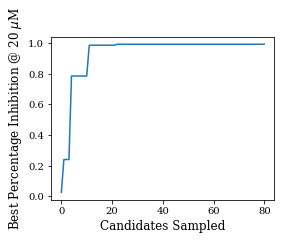

In [43]:
from matplotlib import pyplot as plt
plt.rc('font', family='serif', size=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.figure(figsize=(4, 3))

plt.plot(cummax)

plt.xlabel('Candidates Sampled')
plt.ylabel('Best Percentage Inhibition @ 20 $\mu$M')